# Main Runner

In [1]:
import pandas as pd

from objects import *
import pickle
import os
import matplotlib.pyplot as plt

In [2]:
# Get all files in the experiments folder
experiments = os.listdir('experiments')
# read in pickle object
with open(f"experiments/{experiments[0]}", 'rb') as f:
    exp = pickle.load(f)

In [3]:
csmpo = RigidDayTrading(exp, verbose = True)

In [4]:
market_sim = MarketSimulator(exp,csmpo)

In [5]:
final_portf = market_sim.run()

Starting Simulation


  0%|          | 0/30 [00:00<?, ?it/s]

Current Portfolio Value at 2014-11-03: 259697.0
	 Optimizing with 31 time steps, 2005 constraints, and 2604 variables...
	 Optimized. Time taken: 38.176846981048584


100%|██████████| 30/30 [00:41<00:00,  1.39s/it]


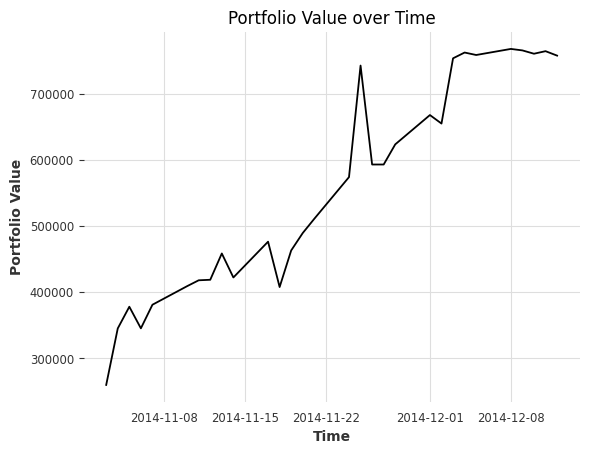

In [6]:
market_sim.plot_value()

Starting Simulation


100%|██████████| 30/30 [02:30<00:00,  5.03s/it]


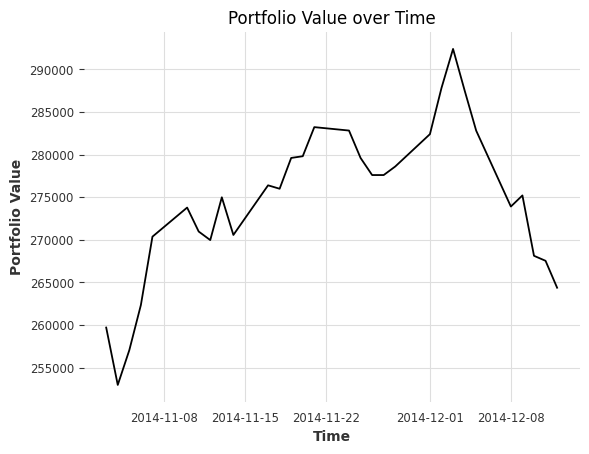

In [7]:
csmpo = DayTradingPolicy(exp, verbose = False)
day_trading_runner = MarketSimulator(exp,csmpo)
day_trading_runner.run()
day_trading_runner.plot_value()